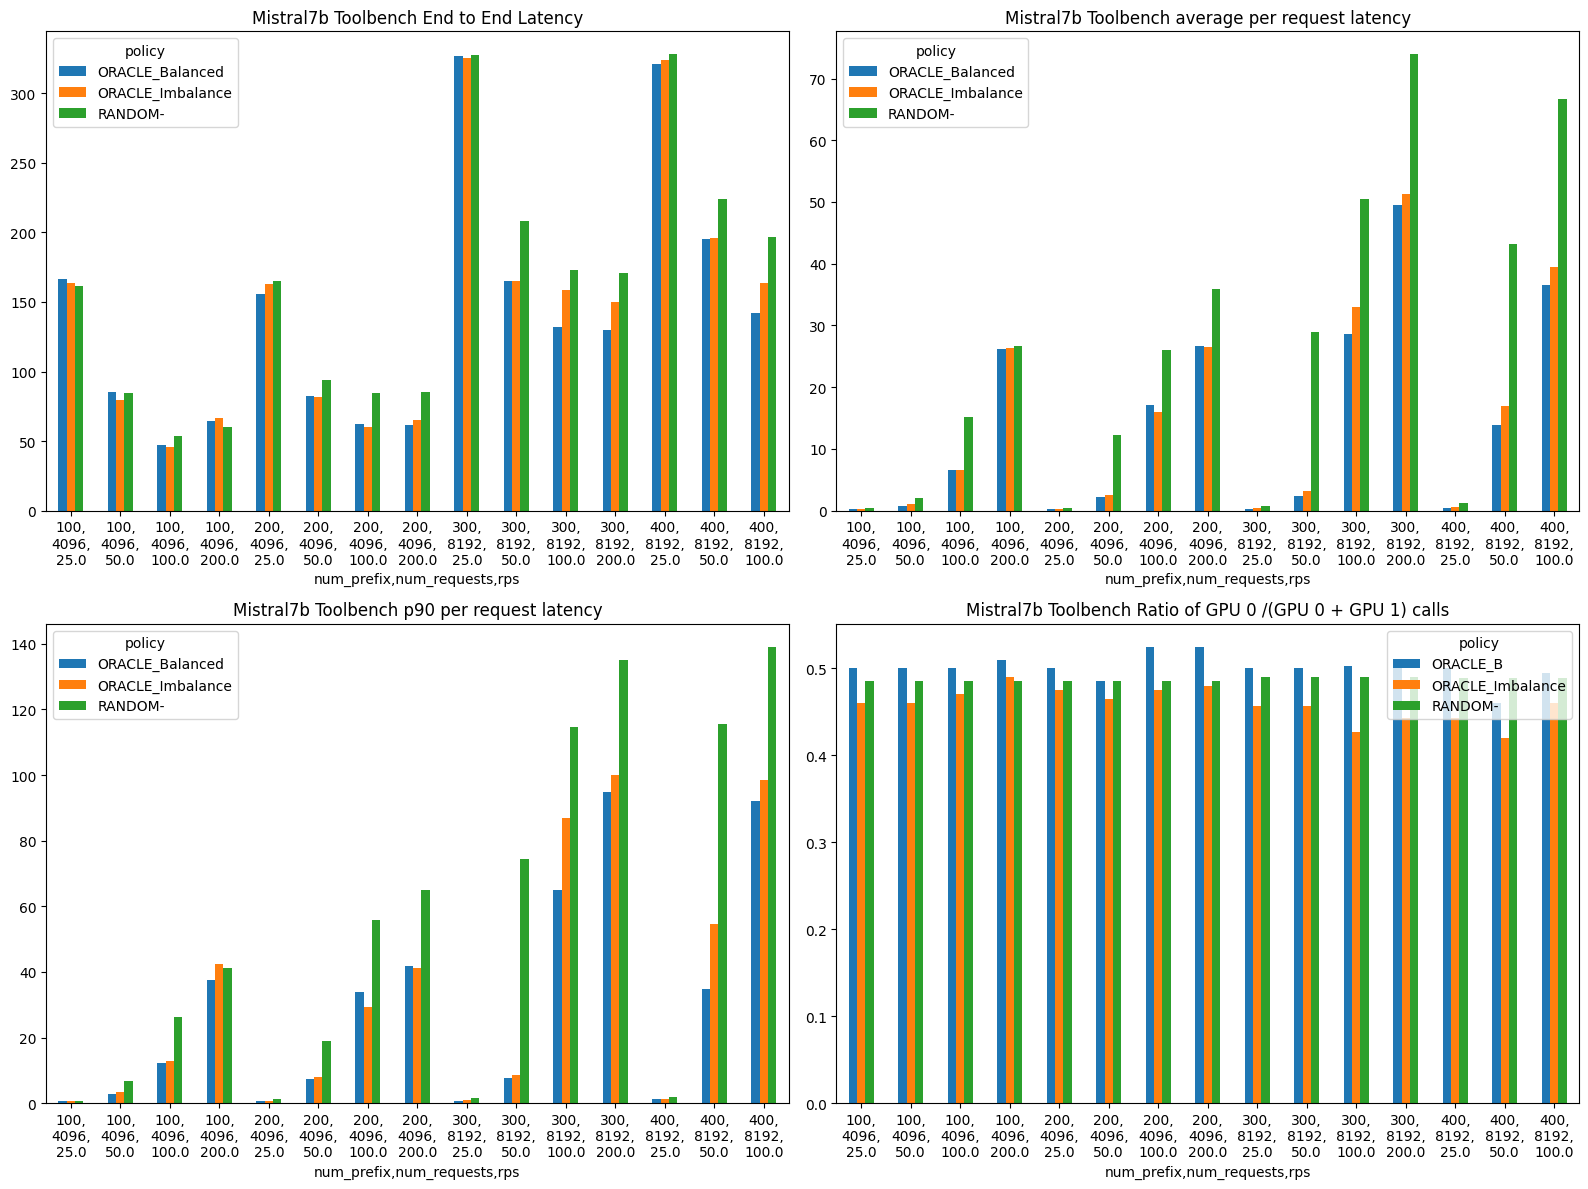

In [140]:
import re
import matplotlib.pyplot as plt
import pandas as pd
import json

def extract_policy_and_number(log_file):
    overall_latencies = []
    overall_throughput = []
    request_latencies = []
    counts_all = []

    with open(log_file, 'r') as f:
        lines = f.readlines()
        for line in lines:
            # Extract lines containing overall latency
            if 'Overall Latency' in line:
                match = re.search(r'Params=\((.+?), (.+?), (.+?), (.+?), (.+?), DataParallelRuntimeSelectionPolicy.(.+?)\) Overall Latency: (.*)', line)
                if match:
                    # if int(match.group(2)) == 300:
                    #     continue
                    overall_latencies.append({
                        "model_name": match.group(1),
                        "num_prefix": int(match.group(2)),
                        "percent_random_prefixes": float(match.group(3)),
                        "num_requests": int(match.group(4)),
                        "rps": float(match.group(5)),
                        "policy": match.group(6).replace("CUSTOM-CustomPolicyType.", ""),
                        "latency": float(match.group(7))
                    })
            elif 'Overall Throughput' in line:
                match = re.search(r'Params=\((.+?), (.+?), (.+?), (.+?), (.+?), DataParallelRuntimeSelectionPolicy.(.+?)\) Overall Throughput: (.*)', line)
                if match:
                    # if int(match.group(2)) == 300:
                    #     continue
                    overall_throughput.append({
                        "model_name": match.group(1),
                        "num_prefix": int(match.group(2)),
                        "percent_random_prefixes": float(match.group(3)),
                        "num_requests": int(match.group(4)),
                        "rps": float(match.group(5)),
                        "policy": match.group(6).replace("CUSTOM-CustomPolicyType.", ""),
                        "throughput": float(match.group(7))
                    })
            elif "Overall Request Latency:" in line:
                match = re.search(r'Params=\((.+?), (.+?), (.+?), (.+?), (.+?), DataParallelRuntimeSelectionPolicy.(.+?)\) Overall Request Latency: (.*), STD: (.*), P90: (.*)', line)
                if match:
                    # if int(match.group(2)) == 300:
                    #     continue
                    request_latencies.append({
                        "model_name": match.group(1),
                        "num_prefix": int(match.group(2)),
                        "percent_random_prefixes": float(match.group(3)),
                        "num_requests": int(match.group(4)),
                        "rps": float(match.group(5)),
                        "policy": match.group(6).replace("CUSTOM-CustomPolicyType.", ""),
                        "avg_latency": float(match.group(7)),
                        "std": float(match.group(8)),
                        "p90": float(match.group(9))
                    })      
            elif "Counts:" in line:
                match = re.search(r'Params=\((.+?), (.+?), (.+?), (.+?), (.+?), DataParallelRuntimeSelectionPolicy.(.+?)\) Counts: (.*)', line)
                if match:
                    count_ratio = eval(match.group(7))
                    for key in count_ratio:
                        count_ratio[key] = float(count_ratio[key])
                    counts_all.append({
                        "model_name": match.group(1),
                        "num_prefix": int(match.group(2)),
                        "percent_random_prefixes": float(match.group(3)),
                        "num_requests": int(match.group(4)),
                        "rps": float(match.group(5)),
                        "policy": match.group(6).replace("CUSTOM-CustomPolicyType.", ""),
                        "counts_all": count_ratio,
                        "ratio": count_ratio[0]/(count_ratio[0]+count_ratio[1])
                    })    

    return overall_latencies, overall_throughput, request_latencies, counts_all

# log_file = 'perf_results_random_vs_oracle_vs_custom_mistral_2_profile_new_results.log'
log_file = 'tool_bench_shuffled.log'
result, overall_throughput, request_latencies, counts_all = extract_policy_and_number(log_file)

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plotting Mistral7b End to End Latency
df = pd.DataFrame(result)
df = df.drop("model_name", axis=1)
df = df.drop('percent_random_prefixes', axis=1)
df['policy'] = df['policy'].replace('ORACLE', 'ORACLE_Imbalance').replace("ORACLE_B", "ORACLE_Balanced")
df = df.groupby(['num_prefix', 'num_requests', 'rps', 'policy'])['latency'].mean().unstack()
plot = df.plot(kind='bar', ax=axes[0, 0], title="Mistral7b Toolbench End to End Latency", rot=0)
x_labels = []
for idx in df.index:
    label = ',\n'.join(str(val) for val in idx)
    x_labels.append(label)

plot.set_xticklabels(x_labels)
# Plotting Mistral7b average per request latency
request_latency_df = pd.DataFrame(request_latencies)
request_latency_df = request_latency_df.drop("model_name", axis=1)
request_latency_df = request_latency_df.drop("percent_random_prefixes", axis=1)
request_latency_df['policy'] = request_latency_df['policy'].replace('ORACLE', 'ORACLE_Imbalance').replace("ORACLE_B", "ORACLE_Balanced")
request_latency_df = request_latency_df.groupby(['num_prefix', 'num_requests', 'rps', 'policy'])["avg_latency"].mean().unstack()
plot = request_latency_df.plot(kind='bar', ax=axes[0, 1], title="Mistral7b Toolbench average per request latency", rot=0)
x_labels = []
for idx in request_latency_df.index:
    label = ',\n'.join(str(val) for val in idx)
    x_labels.append(label)
plot.set_xticklabels(x_labels)


# Plotting Mistral7b p90 per request latency
request_latency_df_90 = pd.DataFrame(request_latencies)
request_latency_df_90 = request_latency_df_90.drop("model_name", axis=1)
request_latency_df_90 = request_latency_df_90.drop("percent_random_prefixes", axis=1)
request_latency_df_90['policy'] = request_latency_df_90['policy'].replace('ORACLE', 'ORACLE_Imbalance').replace("ORACLE_B", "ORACLE_Balanced")
request_latency_df_90 = request_latency_df_90.groupby(['num_prefix','num_requests', 'rps', 'policy'])["p90"].mean().unstack()
plot = request_latency_df_90.plot(kind='bar', ax=axes[1, 0], title="Mistral7b Toolbench p90 per request latency", rot=0)
x_labels = []
for idx in request_latency_df.index:
    label = ',\n'.join(str(val) for val in idx)
    x_labels.append(label)
plot.set_xticklabels(x_labels)

# Plotting Mistral Ratio of GPU 0 /(GPU 0 + GPU 1) calls
count_df = pd.DataFrame(counts_all)
# count_df = count_df.drop("model_name", axis=1)
count_df = count_df.drop("percent_random_prefixes", axis=1)
count_df['policy'] = count_df['policy'].replace('ORACLE', 'ORACLE_Imbalance')
count_df = count_df.groupby(['num_prefix','num_requests', 'rps', 'policy'])["ratio"].mean().unstack()
plot = count_df.plot(kind='bar', ax=axes[1, 1], title="Mistral7b Toolbench Ratio of GPU 0 /(GPU 0 + GPU 1) calls", rot=0)
x_labels = []
for idx in count_df.index:
    label = ',\n'.join(str(val) for val in idx)
    x_labels.append(label)
plot.set_xticklabels(x_labels)

# Adjust layout
plt.tight_layout()
# plt.savefig("Mistral7b Toolbench_grid_results_latency.png")

# Show plot
plt.show()

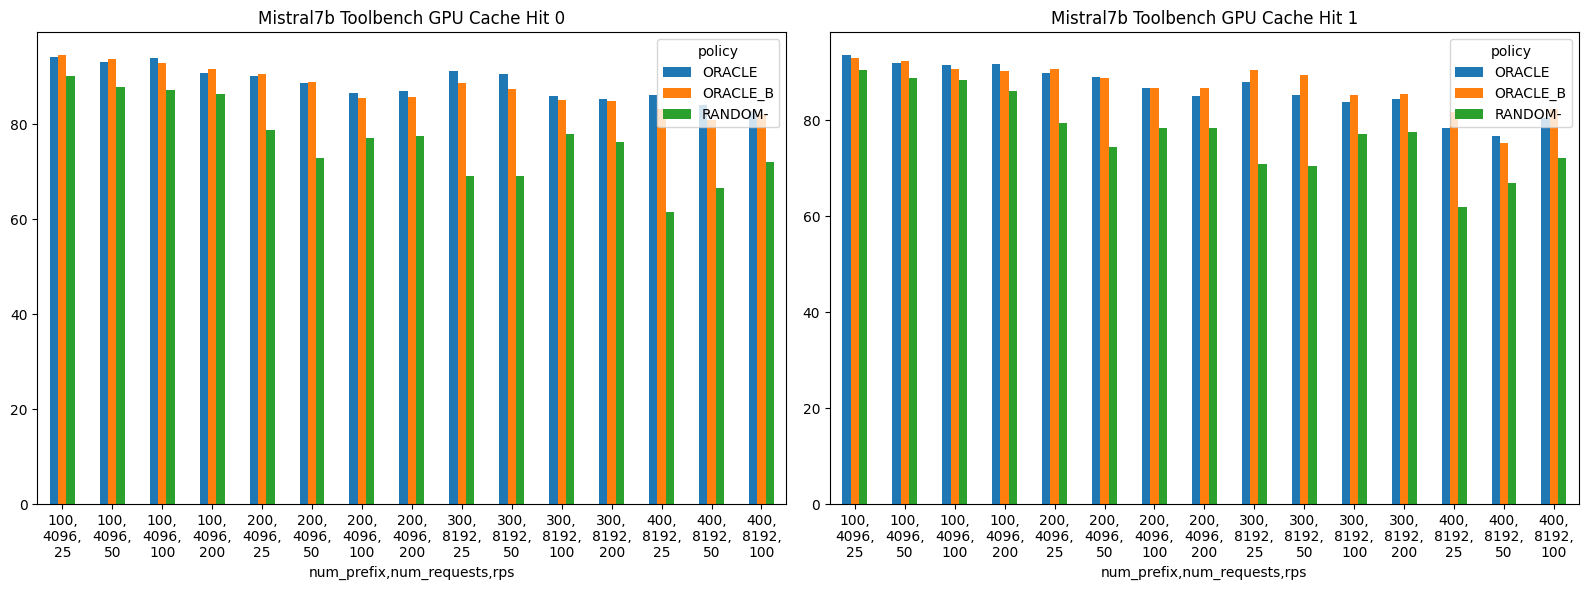

In [141]:

policy_data = []
current_policy_info = {}
max_hit_rate_gpu0 = 0.0
max_hit_rate_gpu1 = 0.0

with open(log_file, 'r') as file:
    for line in file:
        if "=====STARTING Policy" in line:
            # At the start of a new policy, store the max hit rates for both GPUs from the previous group if present
            if current_policy_info:
                current_policy_info['max_tree_cache_hit_rate_gpu0'] = max_hit_rate_gpu0
                current_policy_info['max_tree_cache_hit_rate_gpu1'] = max_hit_rate_gpu1
                policy_data.append(current_policy_info)
            
            # Resetting for the new group
            current_policy_info = {}
            max_hit_rate_gpu0 = 0.0
            max_hit_rate_gpu1 = 0.0
            
            # Extract policy and other properties
            match = re.search(r"=====STARTING Policy (.+?), (\d+) WORKLOADS, ([\d.]+) NON-SHARED, (\d+) REQUESTS, (\d+) REQ/s", line)
            if match:
                current_policy_info['policy'] = match.group(1).replace("DataParallelRuntimeSelectionPolicy.", "").replace("CUSTOM-CustomPolicyType.", "")
                current_policy_info['num_different_long_prefix'] = int(match.group(2))
                current_policy_info['percent_random_prefixes'] = float(match.group(3))
                current_policy_info['num_requests'] = int(match.group(4))
                current_policy_info['rps'] = int(match.group(5))
                
        elif "tree_cache_hit_rate" in line:
            gpu_id_match = re.search(r"GPU: (\d)", line)
            hit_rate_match = re.search(r"tree_cache_hit_rate: ([\d.]+)%", line)
            if gpu_id_match and hit_rate_match:
                gpu_id = int(gpu_id_match.group(1))
                hit_rate = float(hit_rate_match.group(1))
                
                if gpu_id == 0:
                    max_hit_rate_gpu0 = max(max_hit_rate_gpu0, hit_rate)
                elif gpu_id == 1:
                    max_hit_rate_gpu1 = max(max_hit_rate_gpu1, hit_rate)

# Append the last group's data
if current_policy_info:
    current_policy_info['max_tree_cache_hit_rate_gpu0'] = max_hit_rate_gpu0
    current_policy_info['max_tree_cache_hit_rate_gpu1'] = max_hit_rate_gpu1
    policy_data.append(current_policy_info)


# Creating a DataFrame from the list of dictionaries
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plotting Mistral GPU Cache Hit 0
tree_cache_df = pd.DataFrame(policy_data)
tree_cache_df = tree_cache_df.drop('percent_random_prefixes', axis=1)
tree_cache_df = tree_cache_df.rename(columns={'num_different_long_prefix': 'num_prefix'})

tree_cache_df_gpu0 = tree_cache_df.groupby(['num_prefix',  'num_requests', 'rps', 'policy'])["max_tree_cache_hit_rate_gpu0"].mean().unstack()
plot = tree_cache_df_gpu0.plot(kind='bar', ax=axes[0], title="Mistral7b Toolbench GPU Cache Hit 0", rot=0)
x_labels = []
for idx in tree_cache_df_gpu0.index:
    label = ',\n'.join(str(val) for val in idx)
    x_labels.append(label)
plot.set_xticklabels(x_labels)

# Plotting Mistral GPU Cache Hit 1
tree_cache_df_gpu1 = tree_cache_df.groupby(['num_prefix', 'num_requests', 'rps', 'policy'])["max_tree_cache_hit_rate_gpu1"].mean().unstack()
plot = tree_cache_df_gpu1.plot(kind='bar', ax=axes[1], title="Mistral7b Toolbench GPU Cache Hit 1", rot=0)
x_labels = []
for idx in tree_cache_df_gpu1.index:
    label = ',\n'.join(str(val) for val in idx)
    x_labels.append(label)
plot.set_xticklabels(x_labels)

# Adjust layout
plt.tight_layout()
# plt.savefig("mistral_gpu_cache_hit_0.png")
# plt.savefig("Mistral7b Toolbench_gpu_cache_hit_0.png")
# Show plot
plt.show()

In [144]:
df

policy                         ORACLE_Balanced  ORACLE_Imbalance     RANDOM-
num_prefix num_requests rps                                                 
100        4096         25.0        166.575596        163.613888  161.758648
                        50.0         85.125610         79.420969   84.255678
                        100.0        47.073171         45.526315   53.799111
                        200.0        64.608981         66.588216   59.940084
200        4096         25.0        156.072427        163.096402  165.027747
                        50.0         82.246970         82.060382   93.573873
                        100.0        62.144358         59.896077   84.496829
                        200.0        61.699269         65.400400   85.297060
300        8192         25.0        326.689412        325.550524  327.380185
                        50.0        165.235085        165.077648  207.922480
                        100.0       131.800922        158.497217  173.228856
                        200.0       129.944993        150.257514  171.186278
400        8192         25.0        320.840483        323.953068  328.118759
                        50.0        195.441735        195.983588  224.200856
                        100.0       142.022768        163.903128  196.917677

In [143]:
request_latency_df_90

policy                         ORACLE_Balanced  ORACLE_Imbalance     RANDOM-
num_prefix num_requests rps                                                 
100        4096         25.0          0.531091          0.632776    0.813172
                        50.0          2.744993          3.264392    6.764919
                        100.0        12.195439         12.712190   26.196679
                        200.0        37.565470         42.470144   41.282445
200        4096         25.0          0.679289          0.628204    1.249830
                        50.0          7.317701          8.041205   19.089046
                        100.0        33.898250         29.249008   55.962412
                        200.0        41.910896         41.223850   64.893467
300        8192         25.0          0.714249          1.004269    1.502040
                        50.0          7.766287          8.508625   74.566364
                        100.0        65.062126         86.816544  114.692573
                        200.0        94.804736         99.948526  135.112533
400        8192         25.0          1.315409          1.406450    1.765442
                        50.0         34.834502         54.556052  115.565829
                        100.0        92.187852         98.434231  139.138384